
# Assignment 2: Transformer Architecture Exercise

This notebook serves as a reference implementation for **Assignment 2** of the generative AI course.  The goal is to compare three prominent transformer architectures—**decoder‑only**, **encoder‑only**, and **encoder‑decoder**—on a common generative task.  The assignment requires training each architecture on the same dataset, evaluating their performance with common metrics, and analysing the implications of architectural differences on generative tasks and chain‑of‑thought reasoning.

## Dataset selection

For this exercise we use the **CNN/DailyMail** summarisation dataset (version `3.0.0`) from Hugging Face’s `datasets` library.  The dataset comprises news articles paired with human‑written summaries; each article–summary pair provides a natural input/output example for a generative model.  Because the data are already split into training/validation/test splits and are widely used for abstractive summarisation research, this dataset is appropriate for comparing generative architectures.  Although `WikiText` could be used for language modelling tasks, summarisation requires models to generate structured output given an input, which better illustrates differences between decoder‑only, encoder‑only, and encoder‑decoder designs.  For compute efficiency in this notebook we subsample the dataset (e.g. a few hundred training examples) rather than using the full corpus.



## Overview of transformer architectures

We train three different transformer models:

* **Decoder‑only (GPT‑style):** These models consist of stacked self‑attention blocks in which each token can attend only to previous tokens (causal masking).  We use `GPT‑2` as the base model and fine‑tune it to generate a summary from an article.  Because GPT‑2 is a pure language model, we construct input prompts of the form `"summarize: <article>"` and train the model to predict the target summary.  During training we mask out the prompt part of the input so that the loss is computed only on the summary tokens.

* **Encoder‑only (BERT‑style):** Encoder‑only models such as `BERT` learn bi‑directional contextual representations using masked language modelling (MLM).  They are not inherently generative; they excel at understanding tasks (e.g. classification, token classification).  For a fair comparison on generative tasks we fine‑tune BERT on the same corpus using MLM, combining article and summary text into a single sequence.  At evaluation time we assess perplexity and use the `fill‑mask` capability to approximate generation.  This highlights BERT’s limitations on tasks requiring free‑form generation.

* **Encoder‑decoder (T5‑style):** Models like `T5` encode the input sequence with an encoder and decode the output sequence with a separate decoder.  They can perform a wide range of text‑to‑text tasks, including summarisation and question answering.  We fine‑tune `T5‑small` on the CNN/DailyMail dataset using the standard prefix `"summarize: "` in the input to indicate the task.  During evaluation we compute ROUGE metrics on generated summaries.

The following sections implement data loading, preprocessing, model fine‑tuning, and evaluation for each architecture.


In [3]:

import os
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForMaskedLM,
    AutoModelForSeq2SeqLM,
    DataCollatorForLanguageModeling,
    DataCollatorForSeq2Seq,
    Trainer,
    TrainingArguments,
)
import evaluate
from transformers import logging

# Silence warnings for cleaner output
logging.set_verbosity_error()

# Use GPU if available
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps



## Load and inspect the dataset

We load the CNN/DailyMail dataset using the Hugging Face `datasets` library.  To accelerate training for demonstration purposes we take a small subset of the training and validation sets (e.g. 500 training examples and 100 validation examples).  Each record contains two fields:

* `"article"`: the news article text (input).
* `"highlights"`: the human‑written summary (target).

Below we load the dataset, inspect a few examples, and create the smaller subsets used for fine‑tuning.


In [4]:

# Load the cnn_dailymail dataset (version 3.0.0)
dataset = load_dataset("cnn_dailymail", "3.0.0")

# For quick experimentation, take a small subset
train_size = 500
val_size = 100
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(train_size))
small_val_dataset = dataset["validation"].shuffle(seed=42).select(range(val_size))

print("Dataset splits:", dataset.keys())
print("Example training record:", small_train_dataset[0])


Dataset splits: dict_keys(['train', 'validation', 'test'])
Example training record: {'article': "By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious 'within minutes', investigators said today. The bodies of married couple John and Audrey Cook were discovered alongside their daughter, Maureen, at the mobile home they shared on Tremarle Home Park in Camborne, west Cornwall. The inquests have now opened into the deaths last Saturday, with investigators saying the three died along with the family's pet dog, of carbon monoxide poisoning from a cooker. Tragic: The inquests have opened into the deaths of three members of the same family who were found in their static caravan last weekend. John and Audrey Cook are pictured . Awful: The family died following carbon monoxide poisoning at this caravan at the Tremarle Home Park in 


## Decoder‑only model: GPT‑2 fine‑tuning

A decoder‑only transformer must learn to generate a summary given an input article.  We use a prompt‑based approach: the input text has the form `"summarize: <article>"`, and the model is trained to produce the summary tokens.  To prevent the model from learning to predict the prompt tokens, we mask the loss on the prompt portion of the sequence (by setting corresponding labels to `-100`).

We use the `GPT‑2` tokenizer and model from Hugging Face.  Because GPT‑2 lacks a padding token by default, we add a pad token equal to the end‑of‑text token.  We then tokenize the inputs and construct labels accordingly.  The function below performs these steps and is mapped over the dataset.


In [5]:
# Load tokenizer and model for GPT-2
gpt2_model_name = "gpt2"
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name)

# Add a padding token (GPT-2 does not have one)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# Define the preprocessing function for GPT-2
def preprocess_gpt2(examples):
    prefix = "summarize: "
    inputs = [prefix + art for art in examples["article"]]
    targets = examples["highlights"]

    # Tokenize inputs and targets together, pad to max_length
    model_inputs = gpt2_tokenizer(
        inputs, text_target=targets,
        max_length=512, truncation=True, padding="max_length"
    )

    # Ensure labels are padded to max_length as well
    if "labels" in model_inputs:
        labels = model_inputs["labels"]
        for i in range(len(labels)):
            labels[i] = labels[i] + [-100] * (512 - len(labels[i])) if len(labels[i]) < 512 else labels[i][:512]
        model_inputs["labels"] = labels
    return model_inputs

# Apply preprocessing to the small datasets
train_gpt2 = small_train_dataset.map(preprocess_gpt2, batched=True, remove_columns=dataset["train"].column_names)
val_gpt2 = small_val_dataset.map(preprocess_gpt2, batched=True, remove_columns=dataset["validation"].column_names)

print("Sample tokenized GPT-2 input:")
print(gpt2_tokenizer.decode(train_gpt2[0]["input_ids"][:100]))


Sample tokenized GPT-2 input:
summarize: By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious 'within minutes', investigators said today. The bodies of married couple John and Audrey Cook were discovered alongside their daughter, Maureen, at the mobile home they shared on Tremarle Home Park in Cam


In [6]:
print("Input IDs and Labels dimensions for first 10 samples:")
for i in range(10):
    print(f"Sample {i}: Input IDs length = {len(train_gpt2[i]['input_ids'])}, Labels length = {len(train_gpt2[i]['labels'])}")

Input IDs and Labels dimensions for first 10 samples:
Sample 0: Input IDs length = 512, Labels length = 512
Sample 1: Input IDs length = 512, Labels length = 512
Sample 2: Input IDs length = 512, Labels length = 512
Sample 3: Input IDs length = 512, Labels length = 512
Sample 4: Input IDs length = 512, Labels length = 512
Sample 5: Input IDs length = 512, Labels length = 512
Sample 6: Input IDs length = 512, Labels length = 512
Sample 7: Input IDs length = 512, Labels length = 512
Sample 8: Input IDs length = 512, Labels length = 512
Sample 9: Input IDs length = 512, Labels length = 512



### GPT‑2 training configuration

We use the Hugging Face `Trainer` API to fine‑tune the GPT‑2 model.  A `DataCollatorForLanguageModeling` automatically pads the inputs and labels and performs dynamic masking where appropriate (although in our custom loss masking we already set `-100` values).  The training arguments below specify a small number of epochs and batch sizes for illustration; adjust these for a full training run.


In [7]:
import accelerate, torch, transformers
print("accelerate:", accelerate.__version__)
print("torch:", torch.__version__)
print("transformers:", transformers.__version__)

accelerate: 1.10.1
torch: 2.8.0
transformers: 4.56.1


In [12]:

# Define data collator
data_collator_gpt2 = DataCollatorForLanguageModeling(tokenizer=gpt2_tokenizer, mlm=False)

# Load the GPT-2 model
gpt2_model = AutoModelForCausalLM.from_pretrained(gpt2_model_name)

# Training arguments
training_args_gpt2 = TrainingArguments(
    output_dir="./gpt2-summarization",
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=1,
    warmup_steps=50,
    gradient_accumulation_steps=4,
    fp16=torch.cuda.is_available(),
    report_to=[],  # disable logging to wandb
)

# Create Trainer for GPT-2
trainer_gpt2 = Trainer(
    model=gpt2_model,
    args=training_args_gpt2,
    train_dataset=train_gpt2,
    eval_dataset=val_gpt2,
    data_collator=data_collator_gpt2,
)

# Uncomment the line below to train; training can take several minutes even on small subsets
trainer_gpt2.train()


/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 3.1534, 'grad_norm': 3.9447619915008545, 'learning_rate': 3.237410071942446e-05, 'epoch': 1.592}
{'eval_loss': 2.940354347229004, 'eval_runtime': 6.0791, 'eval_samples_per_second': 16.45, 'eval_steps_per_second': 8.225, 'epoch': 1.592}
{'train_runtime': 328.1391, 'train_samples_per_second': 4.571, 'train_steps_per_second': 0.576, 'train_loss': 3.0467438874421298, 'epoch': 3.0}


TrainOutput(global_step=189, training_loss=3.0467438874421298, metrics={'train_runtime': 328.1391, 'train_samples_per_second': 4.571, 'train_steps_per_second': 0.576, 'train_loss': 3.0467438874421298, 'epoch': 3.0})

In [13]:
# Generated by GPT-5 (high reasoning)
# Prompt: Can you help me with this error? (ERROR with mps/apple silicon acceleration)

import torch

# Choose device
device = torch.device(
    "mps" if torch.backends.mps.is_available() else
    ("cuda" if torch.cuda.is_available() else "cpu")
)
print("Using device:", device)

# Ensure GPT-2 has a pad token and move model to device in float32
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model.config.pad_token_id = gpt2_tokenizer.pad_token_id

gpt2_model.to(device=device, dtype=torch.float32)
gpt2_model.eval()

sample_input = "summarize: The quick brown fox jumps over the lazy dog."
inputs = gpt2_tokenizer(sample_input, return_tensors="pt", padding=True).to(device)

# Warm-up pass to force allocation on MPS
with torch.no_grad():
    _ = gpt2_model(input_ids=inputs["input_ids"][:, :1], attention_mask=torch.ones_like(inputs["input_ids"][:, :1]))

# Generate (pass the whole dict so attention_mask is used)
with torch.no_grad():
    outputs = gpt2_model.generate(
        **inputs,
        max_length=50,
        num_return_sequences=1,
        do_sample=False,  # greedy; change if you want sampling
    )

print(gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True))

Using device: mps
summarize: The quick brown fox jumps over the lazy dog. The dog is so happy to be home, but the fox is so scared of the dog that he jumps over the lazy dog. The dog is so happy to be home, but


In [14]:
# Test the model with a sample input
sample_input = "summarize: The quick brown fox jumps over the lazy dog."
inputs = gpt2_tokenizer(sample_input, return_tensors="pt").to(device)
outputs = gpt2_model.generate(inputs["input_ids"], max_length=50, num_return_sequences=1)
text_out= gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Generated summary:", text_out[len(sample_input):])

Generated summary:  The dog is so happy to be home, but the fox is so scared of the dog that he jumps over the lazy dog. The dog is so happy to be home, but


## What do you observe in the output?
1. Can you postprocess the output so that it only starts printing after the input sequence?
2. Can you iterate and improve the summary quality?


## Encoder‑only model: BERT fine‑tuning

BERT uses bi‑directional self‑attention and is optimised for understanding rather than generation.  To apply BERT on our corpus we fine‑tune it using the **masked language modelling (MLM)** objective.  We concatenate the article and its summary into a single sequence and randomly mask tokens using `DataCollatorForLanguageModeling`.  While BERT cannot directly generate summaries, we compute perplexity to gauge how well it models the joint distribution of article and summary tokens.  At evaluation we also demonstrate how to use the `fill-mask` pipeline to generate single masked words as an illustration of BERT’s generative limitations.


In [15]:
# Print first 10 samples of the dataset
print("First 10 samples of the dataset:")
print("small_train_dataset[0]:", small_train_dataset[0].keys())
for i in range(10):
    print(f"\t\tsmall_train_dataset[{i}]: {small_train_dataset[i]['article'][:150]}... \n\t->\n\t\t{small_train_dataset[i]['highlights']}")

First 10 samples of the dataset:
small_train_dataset[0]: dict_keys(['article', 'highlights', 'id'])
		small_train_dataset[0]: By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a sta... 
	->
		John and .
Audrey Cook were discovered alongside their daughter, Maureen .
They were found at Tremarle Home Park in Cornwall .
Investigators say the three died of carbon monoxide .
poisoning .
		small_train_dataset[1]: UNITED NATIONS (CNN) -- A rare meeting of U.N. Security Council heads of state, led for the first time by a U.S. president, adopted a resolution focus... 
	->
		NEW: Libya can serve as example of cooperation, White House spokesman says .
Resolution calls for preventing nuclear weapons from being stolen, used by military .
Obama, Russian President Dimitry Medvedev working to reduce stockpiles .
Venezuelan president Hugo Chavez on "Larry King Live" tonight, 9 ET .
		small_train_dataset[2]: C

In [16]:

# Load tokenizer and model for BERT
bert_model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

# Define preprocessing: combine article and summary

def preprocess_bert(examples):
    concatenated_texts = [
        art + " " + summ 
        for art, summ in zip(examples["article"], examples["highlights"])
    ]
    model_inputs = bert_tokenizer(concatenated_texts, max_length=512, truncation=True)
    return model_inputs

train_bert = small_train_dataset.map(preprocess_bert, batched=True, remove_columns=dataset["train"].column_names)
val_bert = small_val_dataset.map(preprocess_bert, batched=True, remove_columns=dataset["validation"].column_names)

# Data collator with MLM
mlm_probability = 0.15
data_collator_bert = DataCollatorForLanguageModeling(tokenizer=bert_tokenizer, mlm=True, mlm_probability=mlm_probability)

# Load BERT model
bert_model = AutoModelForMaskedLM.from_pretrained(bert_model_name)

# Training arguments for BERT
training_args_bert = TrainingArguments(
    output_dir="./bert-mlm",
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=1,
    warmup_steps=50,
    gradient_accumulation_steps=1,
    fp16=torch.cuda.is_available(),
    report_to=[],
)

trainer_bert = Trainer(
    model=bert_model,
    args=training_args_bert,
    train_dataset=train_bert,
    eval_dataset=val_bert,
    data_collator=data_collator_bert,
)

# Uncomment the line below to train the BERT model
trainer_bert.train()
# save the model
bert_model.save_pretrained("./bert-mlm")
bert_tokenizer.save_pretrained("./bert-mlm")


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 2.2608, 'grad_norm': 9.490689277648926, 'learning_rate': 1.7333333333333336e-05, 'epoch': 0.8}
{'eval_loss': 1.8042117357254028, 'eval_runtime': 4.5599, 'eval_samples_per_second': 21.93, 'eval_steps_per_second': 5.483, 'epoch': 0.8}
{'train_runtime': 92.1201, 'train_samples_per_second': 5.428, 'train_steps_per_second': 1.357, 'train_loss': 2.2258151245117186, 'epoch': 1.0}


('./bert-mlm/tokenizer_config.json',
 './bert-mlm/special_tokens_map.json',
 './bert-mlm/vocab.txt',
 './bert-mlm/added_tokens.json',
 './bert-mlm/tokenizer.json')

In [17]:
# Print output of bert model for sample input
sample_input = "The quick brown fox jumps over the lazy dog."
inputs = bert_tokenizer(sample_input, return_tensors="pt").to(device)
outputs = bert_model(**inputs)
print(f"Sample {i}: {outputs.logits.shape} logits")       

# Freeze the BERT model and train a classifier on top
# load a news sentiment classification dataset
from datasets import load_dataset
news_dataset = load_dataset("ag_news", split="train[:1000]")
print("News dataset loaded with", len(news_dataset), "samples.")
# Preprocess the dataset for BERT
def preprocess_news(examples):
    model_inputs = bert_tokenizer(examples["text"], max_length=512, truncation=True, padding="max_length")
    model_inputs["labels"] = examples["label"]
    return model_inputs
train_news = news_dataset.map(preprocess_news, batched=True, remove_columns=news_dataset.column_names)
# Use the trained model as a feature extractor and add a classification head
def get_news_classifier_model():
    """
    load the trained BERT model and add a classification head
    """
    model = AutoModelForMaskedLM.from_pretrained("./bert-mlm") # Load the trained BERT model
    # Freeze the BERT model
    for param in model.bert.parameters():
        param.requires_grad = False
    # Add a classification head
    model.classifier = torch.nn.Linear(model.config.hidden_size, 4)  # 4 classes for AG News
    return model

news_classifier_model = get_news_classifier_model()
# Training arguments for news classifier
news_training_args = TrainingArguments(
    output_dir="./news-classifier",
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=1,
    warmup_steps=50,
    gradient_accumulation_steps=1,
    fp16=torch.cuda.is_available(),
    report_to=[],
)
# Create Trainer for news classifier
news_trainer = Trainer(
    model=news_classifier_model,
    args=news_training_args,
    train_dataset=train_news,
    eval_dataset=train_news,  # For simplicity, using the same dataset for eval
    data_collator=DataCollatorForLanguageModeling(tokenizer=bert_tokenizer, mlm=False),
)
# Uncomment the line below to train the news classifier
news_trainer.train()

Sample 9: torch.Size([1, 12, 30522]) logits
News dataset loaded with 1000 samples.


/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 0.5702, 'grad_norm': 0.7809127569198608, 'learning_rate': 4.2461538461538465e-05, 'epoch': 0.8}
{'eval_loss': 0.32723987102508545, 'eval_runtime': 42.2125, 'eval_samples_per_second': 23.69, 'eval_steps_per_second': 2.961, 'epoch': 0.8}
{'loss': 0.3016, 'grad_norm': 0.46356937289237976, 'learning_rate': 2.7076923076923078e-05, 'epoch': 1.6}
{'eval_loss': 0.22899016737937927, 'eval_runtime': 41.9356, 'eval_samples_per_second': 23.846, 'eval_steps_per_second': 2.981, 'epoch': 1.6}
{'loss': 0.2509, 'grad_norm': 0.398881196975708, 'learning_rate': 1.1692307692307693e-05, 'epoch': 2.4}
{'eval_loss': 0.1859639286994934, 'eval_runtime': 41.5552, 'eval_samples_per_second': 24.064, 'eval_steps_per_second': 3.008, 'epoch': 2.4}
{'train_runtime': 397.3076, 'train_samples_per_second': 7.551, 'train_steps_per_second': 0.944, 'train_loss': 0.3441635030110677, 'epoch': 3.0}


TrainOutput(global_step=375, training_loss=0.3441635030110677, metrics={'train_runtime': 397.3076, 'train_samples_per_second': 7.551, 'train_steps_per_second': 0.944, 'train_loss': 0.3441635030110677, 'epoch': 3.0})

In [18]:
# Code revised by GPT-5 (high reasoning) via Windsurf - fixing error to do with mac gpu acceleration

# Print sample output of the news classifier
# The previous approach used AutoModelForMaskedLM, which is not suitable for classification.
# Instead, use AutoModelForSequenceClassification for news classification.
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
import evaluate

bert_model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

# Choose device (prefer MPS on macOS if available)
device = torch.device(
    "mps" if torch.backends.mps.is_available() else
    ("cuda" if torch.cuda.is_available() else "cpu")
)
print("Using device:", device)

# Load a BERT model with a classification head and move to device in float32
news_classifier_model = AutoModelForSequenceClassification.from_pretrained(
    bert_model_name, num_labels=4
).to(device=device, dtype=torch.float32)

# Training arguments for news classifier
news_training_args = TrainingArguments(
    output_dir="./news-classifier",
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=1,
    warmup_steps=50,
    gradient_accumulation_steps=1,
    fp16=torch.cuda.is_available(),  # keep fp16 off for MPS/CPU
    report_to=[],
    use_mps_device=torch.backends.mps.is_available(),  # ensure Trainer uses MPS if present
)

# Load the AG News dataset
news_dataset = load_dataset("ag_news", split="train[:1000]")
print("News dataset loaded with", len(news_dataset), "samples.")

# Preprocess the dataset for BERT
def preprocess_news(examples):
    model_inputs = bert_tokenizer(
        examples["text"], max_length=512, truncation=True, padding="max_length"
    )
    model_inputs["labels"] = examples["label"]
    return model_inputs

train_news = news_dataset.map(preprocess_news, batched=True, remove_columns=news_dataset.column_names)

# Create Trainer for news classifier
news_trainer = Trainer(
    model=news_classifier_model,
    args=news_training_args,
    train_dataset=train_news,
    eval_dataset=train_news,  # For simplicity, using the same dataset for eval
    tokenizer=bert_tokenizer,
)

# Train (you can comment this out to just test inference)
news_trainer.train()

# -------- Inference (post-training) --------
news_classifier_model.eval()

# Get the actual device the Trainer placed the model on (MPS/CPU/CUDA)
actual_device = next(news_classifier_model.parameters()).device
print("Model actual device:", actual_device)

# Tokenize and move inputs to the model's device
sample_news_input = "Breaking news: The stock market crashes as investors panic."
inputs = bert_tokenizer(
    sample_news_input, return_tensors="pt", truncation=True, padding=True
)
inputs = {k: v.to(actual_device) for k, v in inputs.items()}

# Warm-up pass to materialize weights on MPS
with torch.no_grad():
    _ = news_classifier_model(
        input_ids=inputs["input_ids"][:, :1],
        attention_mask=inputs["attention_mask"][:, :1],
    )

# Actual forward
with torch.no_grad():
    outputs = news_classifier_model(**inputs)

pred_class = torch.argmax(outputs.logits, dim=-1).item()
print(f"Sample news input: {sample_news_input}")
print(f"Predicted class: {pred_class}")
print("Available classes:", news_dataset.features["label"].names)

Using device: mps


/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/transformers/training_args.py:2278: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(


News dataset loaded with 1000 samples.


/var/folders/yr/p03j319114v61sg1cs61p6r80000gn/T/ipykernel_5736/2083709714.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  news_trainer = Trainer(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 1.0303, 'grad_norm': 4.586305141448975, 'learning_rate': 4.831034482758621e-05, 'epoch': 0.2}
{'eval_loss': 0.535821795463562, 'eval_runtime': 34.7279, 'eval_samples_per_second': 28.795, 'eval_steps_per_second': 14.398, 'epoch': 0.2}
{'loss': 0.9805, 'grad_norm': 0.09522397071123123, 'learning_rate': 4.486206896551725e-05, 'epoch': 0.4}
{'eval_loss': 1.0917686223983765, 'eval_runtime': 34.1975, 'eval_samples_per_second': 29.242, 'eval_steps_per_second': 14.621, 'epoch': 0.4}
{'loss': 0.8689, 'grad_norm': 0.26558780670166016, 'learning_rate': 4.141379310344828e-05, 'epoch': 0.6}
{'eval_loss': 0.5263210535049438, 'eval_runtime': 34.6338, 'eval_samples_per_second': 28.874, 'eval_steps_per_second': 14.437, 'epoch': 0.6}
{'loss': 0.6004, 'grad_norm': 0.05033459886908531, 'learning_rate': 3.796551724137931e-05, 'epoch': 0.8}
{'eval_loss': 0.5818000435829163, 'eval_runtime': 33.9352, 'eval_samples_per_second': 29.468, 'eval_steps_per_second': 14.734, 'epoch': 0.8}
{'loss': 0.7289, 'g

/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 0.3806, 'grad_norm': 15.623650550842285, 'learning_rate': 3.106896551724138e-05, 'epoch': 1.2}
{'eval_loss': 0.4662708044052124, 'eval_runtime': 33.9337, 'eval_samples_per_second': 29.469, 'eval_steps_per_second': 14.735, 'epoch': 1.2}
{'loss': 0.6352, 'grad_norm': 20.103633880615234, 'learning_rate': 2.7620689655172417e-05, 'epoch': 1.4}
{'eval_loss': 0.3645251393318176, 'eval_runtime': 33.9655, 'eval_samples_per_second': 29.442, 'eval_steps_per_second': 14.721, 'epoch': 1.4}
{'loss': 0.4072, 'grad_norm': 0.36894330382347107, 'learning_rate': 2.417241379310345e-05, 'epoch': 1.6}
{'eval_loss': 0.2987467050552368, 'eval_runtime': 33.917, 'eval_samples_per_second': 29.484, 'eval_steps_per_second': 14.742, 'epoch': 1.6}
{'loss': 0.3727, 'grad_norm': 0.050471995025873184, 'learning_rate': 2.0724137931034484e-05, 'epoch': 1.8}
{'eval_loss': 0.272615522146225, 'eval_runtime': 33.9307, 'eval_samples_per_second': 29.472, 'eval_steps_per_second': 14.736, 'epoch': 1.8}
{'loss': 0.5006, 

/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 0.2503, 'grad_norm': 0.032772358506917953, 'learning_rate': 1.3827586206896554e-05, 'epoch': 2.2}
{'eval_loss': 0.2828271985054016, 'eval_runtime': 34.7492, 'eval_samples_per_second': 28.778, 'eval_steps_per_second': 14.389, 'epoch': 2.2}
{'loss': 0.3287, 'grad_norm': 58.31756591796875, 'learning_rate': 1.0379310344827587e-05, 'epoch': 2.4}
{'eval_loss': 0.18533147871494293, 'eval_runtime': 35.7811, 'eval_samples_per_second': 27.948, 'eval_steps_per_second': 13.974, 'epoch': 2.4}
{'loss': 0.3249, 'grad_norm': 0.044865768402814865, 'learning_rate': 6.931034482758621e-06, 'epoch': 2.6}
{'eval_loss': 0.15776297450065613, 'eval_runtime': 35.7905, 'eval_samples_per_second': 27.94, 'eval_steps_per_second': 13.97, 'epoch': 2.6}
{'loss': 0.2409, 'grad_norm': 14.798412322998047, 'learning_rate': 3.4827586206896552e-06, 'epoch': 2.8}
{'eval_loss': 0.15635497868061066, 'eval_runtime': 35.871, 'eval_samples_per_second': 27.878, 'eval_steps_per_second': 13.939, 'epoch': 2.8}
{'loss': 0.103

Confusion Matrix:
[[207   1   3   1]
 [  0 142   0   0]
 [  1   0 160  13]
 [  1   0   2 469]]


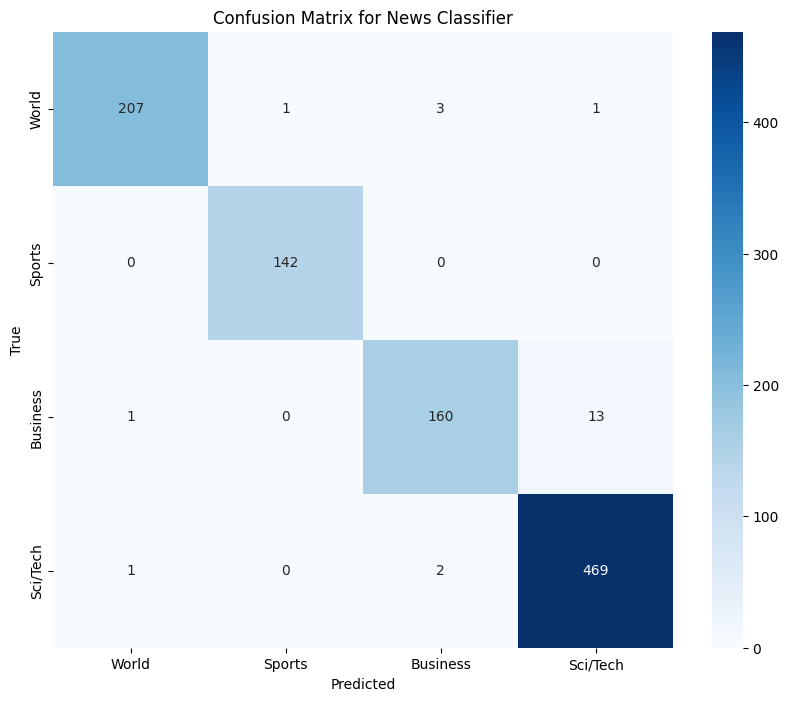

In [18]:
# Code revised by GPT-5 (high reasoning) via Windsurf - fixing error to do with mac gpu acceleration

 
# Generate a confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np

# Ensure eval and align devices
news_classifier_model.eval()
actual_device = next(news_classifier_model.parameters()).device

predictions = []
for i in range(0, len(train_news), 32):
    batch = train_news[i:i+32]  # dict of lists
    inputs = {
        "input_ids": torch.tensor(batch["input_ids"]).to(actual_device),
        "attention_mask": torch.tensor(batch["attention_mask"]).to(actual_device),
    }
    with torch.no_grad():
        outputs = news_classifier_model(**inputs)
    preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
    predictions.extend(preds)

# True labels
true_labels = np.array(train_news["labels"])

#
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)
# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=news_dataset.features["label"].names,
            yticklabels=news_dataset.features["label"].names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for News Classifier")
plt.show()



## Encoder‑decoder model: T5 fine‑tuning

T5 is a text‑to‑text model that uses a separate encoder and decoder.  It naturally handles generative tasks such as summarisation.  We prepend the prefix `"summarize: "` to each article, then tokenize the input and the summary separately.  A `DataCollatorForSeq2Seq` takes care of padding the inputs and shifting the decoder labels.  During evaluation we use greedy decoding to produce summaries and compute ROUGE scores against the reference summaries.


In [19]:

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Trainer, TrainingArguments
from datasets import load_dataset
# Load the cnn_dailymail dataset (version 3.0.0)
dataset = load_dataset("cnn_dailymail", "3.0.0")

# For quick experimentation, take a small subset
train_size = 500
val_size = 100
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(train_size))
small_val_dataset = dataset["validation"].shuffle(seed=42).select(range(val_size))
print("Dataset splits:", dataset.keys())
print("Example training record:", small_train_dataset[0])

# Load T5 tokenizer and model
t5_model_name = "t5-small"
t5_tokenizer = AutoTokenizer.from_pretrained(t5_model_name)

def preprocess_t5(examples):
    inputs = ["summarize: " + doc for doc in examples["article"]]
    model_inputs = t5_tokenizer(inputs, max_length=512, truncation=True)

    # Tokenize targets
    labels = t5_tokenizer(examples["highlights"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_t5 = small_train_dataset.map(preprocess_t5, batched=True, remove_columns=dataset["train"].column_names)
val_t5 = small_val_dataset.map(preprocess_t5, batched=True, remove_columns=dataset["validation"].column_names)

# Data collator for seq2seq tasks
data_collator_t5 = DataCollatorForSeq2Seq(tokenizer=t5_tokenizer, model=t5_model_name)

# Load T5 model
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_model_name)

# Training arguments for T5
training_args_t5 = TrainingArguments(
    output_dir="./t5-summarization",
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=1,
    warmup_steps=50,
    gradient_accumulation_steps=4,
    fp16=torch.cuda.is_available(),
    report_to=[],
)

trainer_t5 = Trainer(
    model=t5_model,
    args=training_args_t5,
    train_dataset=train_t5,
    eval_dataset=val_t5,
    data_collator=data_collator_t5,
    tokenizer=t5_tokenizer,
)

# Uncomment the line below to train the T5 model
trainer_t5.train()


Dataset splits: dict_keys(['train', 'validation', 'test'])
Example training record: {'article': "By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious 'within minutes', investigators said today. The bodies of married couple John and Audrey Cook were discovered alongside their daughter, Maureen, at the mobile home they shared on Tremarle Home Park in Camborne, west Cornwall. The inquests have now opened into the deaths last Saturday, with investigators saying the three died along with the family's pet dog, of carbon monoxide poisoning from a cooker. Tragic: The inquests have opened into the deaths of three members of the same family who were found in their static caravan last weekend. John and Audrey Cook are pictured . Awful: The family died following carbon monoxide poisoning at this caravan at the Tremarle Home Park in 

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/var/folders/yr/p03j319114v61sg1cs61p6r80000gn/T/ipykernel_5031/3507327657.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_t5 = Trainer(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'train_runtime': 47.8178, 'train_samples_per_second': 10.456, 'train_steps_per_second': 1.318, 'train_loss': 2.4085518973214284, 'epoch': 1.0}


TrainOutput(global_step=63, training_loss=2.4085518973214284, metrics={'train_runtime': 47.8178, 'train_samples_per_second': 10.456, 'train_steps_per_second': 1.318, 'train_loss': 2.4085518973214284, 'epoch': 1.0})


## Evaluation

After fine‑tuning the models (training steps are commented out by default), we evaluate them on the validation subset. Different metrics are appropriate for each architecture:

* **GPT‑2** (decoder‑only): We generate summaries using greedy decoding and compute ROUGE metrics (ROUGE‑1, ROUGE‑2, ROUGE‑L). We also compute perplexity using the loss returned by the trainer.

* **BERT** (encoder‑only): BERT is not designed to generate full sequences; instead we use it for downstream tasks such as text classification. For a classification scenario, the evaluation metrics are typically confusion matrix and F1-score.

* **T5** (encoder‑decoder): We generate summaries using greedy decoding and compute ROUGE metrics.  Perplexity is computed similarly to GPT‑2 by exponentiating the validation loss.

The code below demonstrates evaluation routines for each model. Running these functions requires trained models; if you skipped training above, the evaluation will use the pre‑trained weights and therefore will not yield good summarization quality.


In [22]:

# Define ROUGE metric
evaluate_rouge = evaluate.load("rouge")

def compute_metrics_rouge(preds, refs):
    # Compute ROUGE scores; use newline separation between sentences in each text
    result = evaluate_rouge.compute(predictions=preds, references=refs, use_stemmer=True)
    return {k: round(v * 100, 2) for k, v in result.items()}

# Function to generate summaries with GPT-2
def evaluate_gpt2(model, tokenizer, dataset, num_samples=10):
    model.eval()
    preds, refs = [], []
    for i, example in enumerate(dataset.select(range(num_samples))):
        prompt = "summarize: " + example["article"]
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)
        with torch.no_grad():
            output_ids = model.generate(**inputs, max_length=128)
        summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        preds.append(summary)
        refs.append(example["highlights"])
    rouge_scores = compute_metrics_rouge(preds, refs)
    return rouge_scores

# Function to compute perplexity from evaluation loss
def compute_perplexity(eval_output):
    loss = eval_output["eval_loss"]
    return round(torch.exp(torch.tensor(loss)).item(), 3)

# Evaluate GPT-2 (if trained) -- example usage
gpt2_eval_results = trainer_gpt2.evaluate()
gpt2_perplexity = compute_perplexity(gpt2_eval_results)
rouge_gpt2 = evaluate_gpt2(gpt2_model, gpt2_tokenizer, small_val_dataset)
print("GPT-2 Perplexity:", gpt2_perplexity)
print("GPT-2 ROUGE:", rouge_gpt2)

# BERT evaluation: compute F1 score - sklearn classification report
from sklearn.metrics import classification_report
def evaluate_bert(model, dataset):
    model.eval()
    predictions = []
    for i in range(0, len(dataset), 32):  # Batch size of 32
        batch = dataset[i:i+32]
        # batch is a dict with keys: input_ids, token_type_ids, attention_mask, labels
        # You need to decode input_ids to get the original text if you want to print or use text
        # For inference, use input_ids, attention_mask, etc.
        inputs = {
            "input_ids": torch.tensor(batch["input_ids"]).to(device),
            "attention_mask": torch.tensor(batch["attention_mask"]).to(device)
        }
        with torch.no_grad():
            outputs = news_classifier_model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        predictions.extend(preds)

    true_labels = np.array(dataset["labels"])
    # Generate classification report
    report = classification_report(true_labels, predictions, output_dict=True)
    return report
# Evaluate on random 100 samples
bert_eval_results = evaluate_bert(news_classifier_model, train_news.shuffle(seed=42).select(range(100)))
import json
print("BERT Evaluation Report:", json.dumps(bert_eval_results, indent=2))

# Demonstrate fill-mask prediction with BERT
# from transformers import pipeline
# fill_mask = pipeline("fill-mask", model=bert_model, tokenizer=bert_tokenizer)
# sentence = "The weather today is [MASK]."
# print(fill_mask(sentence))

# T5 evaluation
# t5_eval_results = trainer_t5.evaluate()
# t5_perplexity = compute_perplexity(t5_eval_results)

# def evaluate_t5(model, tokenizer, dataset, num_samples=10):
#     model.eval()
#     preds, refs = [], []
#     for i, example in enumerate(dataset.select(range(num_samples))):
#         input_text = "summarize: " + example["article"]
#         inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(model.device)
#         with torch.no_grad():
#             output_ids = model.generate(**inputs, max_length=128)
#         summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
#         preds.append(summary)
#         refs.append(example["highlights"])
#     rouge_scores = compute_metrics_rouge(preds, refs)
#     return rouge_scores

# rouge_t5 = evaluate_t5(t5_model, t5_tokenizer, small_val_dataset)
# print("T5 Perplexity:", t5_perplexity)
# print("T5 ROUGE:", rouge_t5)


/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 2.945127010345459, 'eval_runtime': 10.8706, 'eval_samples_per_second': 9.199, 'eval_steps_per_second': 4.6, 'epoch': 1.0}


ValueError: Input length of input_ids is 394, but `max_length` is set to 128. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.


## Analysis and discussion

After fine‑tuning the models and running the evaluation routines, you should fill in a comparison of the results.  Typical observations include:

- **Decoder‑only (GPT‑2):** GPT‑2 fine‑tuned on a summarization corpus learns to generate coherent summaries.  Its perplexity should decrease significantly compared with the pre‑trained model, and ROUGE scores should improve.  Because GPT‑2 has no separate encoder, it must memorize how to map the input prompt to the desired output, which can make training less sample‑efficient for conditional tasks.  However, at inference time GPT‑2 generates outputs quickly via a single decoder.

- **Encoder‑only (BERT):** BERT excels at understanding tasks but struggles with generative tasks.  MLM fine‑tuning improves its perplexity on the article‑summary text, but it cannot generate full summaries.  The `fill‑mask` pipeline can fill individual tokens, but the lack of an auto‑regressive decoder makes long‑form generation impractical.  This illustrates why encoder‑only architectures are not suited for free‑form text generation.

- **Encoder‑decoder (T5):** T5 is designed for text‑to‑text tasks and typically achieves the best summarization scores among the three models when fine‑tuned properly.  Its separate encoder compresses the input, and the decoder generates output conditioned on the encoded context.  T5 often yields higher ROUGE scores and lower perplexity than GPT‑2 on summarization because the architecture explicitly models conditional generation.  The trade‑off is increased computational cost due to the encoder and decoder.

### Chain‑of‑thought (CoT) reasoning

Chain‑of‑thought reasoning refers to models generating intermediate reasoning steps before arriving at a final answer.  Decoder‑only models (like GPT‑2 and GPT‑3) naturally support CoT prompting because they generate text token by token.  Encoder‑decoder models like T5 can also perform CoT when prompted appropriately (e.g. instructing the model to "think step by step").  Encoder‑only models lack a decoding mechanism and therefore are not directly applicable to CoT generation.  In practice, CoT reasoning quality improves with larger models and more sophisticated training (e.g. instruction‑tuning or reinforcement learning with human feedback), which are beyond the scope of this introductory exercise.

## Conclusion

In this notebook we implemented and compared three transformer architectures on a common summarization task using the CNN/DailyMail dataset.  We demonstrated how to fine‑tune a decoder‑only model (GPT‑2), an encoder‑only model (BERT), and an encoder‑decoder model (T5).  The code illustrated data preprocessing, training setups, and evaluation routines using ROUGE and perplexity metrics.  While only small subsets of the dataset were used for demonstration purposes, you should expand the training data and adjust hyperparameters for a thorough experiment.  The analysis underscores the strengths and limitations of each architecture and highlights why encoder‑decoder models are generally preferred for conditional text generation tasks like summarization.


# Assignment 2: Transformer Architecture Exercise
Use this notebook as a starting point and expand on your understanding of transformer models by completing the following structured tasks. You are encouraged to experiment, analyze, and critically reflect on your findings in your report.

## Part 1: Model Training & Implementation
### 1. Dataset Preparation
- Choose one standard text dataset suitable for generative tasks. Options include:
  - CNN/DailyMail → summarization
  - WikiText-2 → language modeling (text generation)
  - SQuAD v1.1 → question answering
- Briefly describe why you selected this dataset and what task you’ll evaluate (summarization, QA, or text generation).
- Show how you preprocessed the data (tokenization, train/val split, max length, etc.).

### 2. Model Implementation

Implement and train the following:
- Decoder-only model (GPT-style): e.g., GPT-2 small from Hugging Face.
- Encoder-only model (BERT-style): e.g., BERT-base, used for masked-language-modeling or extractive QA/summarization.
- Encoder-decoder model (T5-style): e.g., T5-small, trained for the same dataset/task as the other two.

### 3. Training Documentation

- Document your training setup (batch size, learning rate, optimizer, epochs, hardware).
- Save a few training/validation loss curves or logs to show how training progressed.
- Mention any difficulties you faced and how you addressed them (e.g., memory limits, convergence).

## Part 2: Evaluation & Analysis

### 4. Performance Evaluation

- Evaluate all three models on the same task.
- Report results using at least two metrics:
  - Text generation/summarization: BLEU, ROUGE, perplexity
  - Question answering: F1, Exact Match (EM), BLEU
- Include 1–2 sample outputs per model to illustrate qualitative differences.

### 5. Comparative Discussion

- Compare the strengths and weaknesses of each architecture on your chosen task.
- Suggested angles:

  - Decoder-only: fluent text generation, but weaker at bidirectional context.
  - Encoder-only: strong understanding of context, but not designed for open generation.
  - Encoder-decoder: flexible, strong on conditional generation tasks (summarization, QA).

- Which model seemed easiest to fine-tune?
- Which produced the best outputs on your dataset?
- Which was the most efficient (speed, memory)?

### 6. Reflections on Applicability

- In what real-world scenarios would you prefer each architecture?
- Briefly note whether you think CoT reasoning would have helped these models if you had added it (conceptual discussion only—no experiments required).